# Problem 7, HW9

Consider a group of $n$ roommate pairs at Harvard (so there are $2n$ students). Each of these $2n$ students independently decides randomly whether to take STAT 110, with probability $p$ of "success" (where "success" is defined as taking STAT 110).

Let $N$ be the number of students among these $2n$ students who take STAT 110, and let $X$ be the number of roommate pairs where both roommates in the pair take STAT 110.

Find $E(X)$ and $E(X|N)$.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

In [2]:
# Import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import inspect
from functools import wraps
from math import floor, comb
from scipy.stats import binom

First, let's start by writing code that will simulate outcomes for $X$.

In [3]:
def get_default_args(func):
    """
    Returns dictionary of default arguments for a function `func`
    """
    signature = inspect.signature(func)
    return {
        k: v.default
        for k, v in signature.parameters.items()
        if v.default is not inspect.Parameter.empty
    }


def data_generator(max_n=100):
    """
    Decorator factory that allows user to set `max_n` when generating dataframe of n, E(X)
    """
    def decorator(func):
        """
        Decorator that extends random variable `func` by producing Pandas DataFrame of outcomes
        """
        @wraps(func)
        def wrapper(*args, **kwargs):
            _, p = args
            kwds = get_default_args(func)
            kwds.update(kwargs)
            x = list(range(1, max_n + 1))
            data = pd.DataFrame(zip(x, [func(n=i, p=p, trials=kwds['trials']).mean() for i in x]), columns=['n', 'E(X)'])
            data['p'] = p
            return data
        return wrapper
    return decorator


# Remove this decorator to see results from a single `n`, `p` pair
@data_generator(100)
def X_outcomes(n: int, p: float, trials: int = 10_000) -> list:
    """
    Returns `trials` number of outcomes for random variable X based on `n`
    pairs of students with each student independently taking STAT 110 with
    probability `p`.
    """
    # Population of students as array: [1, 2, ..., n, 1, 2, ..., n]
    students = np.tile(np.arange(1, n+1, 1), 2)

    # Run experiment
    results = []
    for _ in range(trials):
        mask = np.random.choice([True, False], size=2*n, replace=True, p=[p, 1-p])
        freq = np.bincount(students[mask])
        ii = np.nonzero(freq)[0]
        results.append(len([x[0] for x in zip(ii, freq[ii]) if x[1] > 1]))
        
    return np.array([results])

Let's plot $E(X)$ as a function of $n$ for a fixed $p$.

In [4]:
# Estimates for E(X) for varying `n` 
# NOTE: Decorated function handles all reasonable cases of `n`
_ = 10
p = 0.2

data = X_outcomes(_, p)

data.sample(5)

,n,E(X),p
60,61,2.4475,0.2
45,46,1.8468,0.2
86,87,3.4764,0.2
71,72,2.8950,0.2
13,14,0.5600,0.2


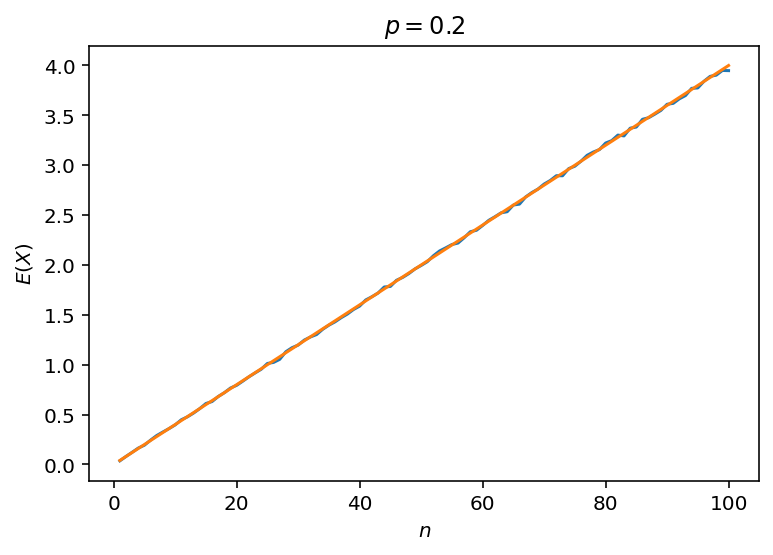

In [5]:
# Plot relationship
plt.plot(data['n'], data['E(X)'])
plt.plot(data['n'], data['n'] * data['p'] ** 2)
plt.xlabel(r'$n$')
plt.ylabel(r'$E(X)$')
plt.title(r'$p = 0.2$')
plt.show()

Interestingly, this relationship looks strikingly linear! In fact, the relationship seems to be $E(X) = np^{2}$. This makes sense by the **Fundamental Bridge**, **linearity of expectation**, **symmetry** , and **independence**.

Letting $I_{1, j}$ and $I_{2,j}$ be the indicator random variables for the first and second member of the $j$th roommate pair, then:

$$
\begin{align}
X &= I_{1,1}I_{2,1} + I_{1,2}I_{2,2} + ... + I_{1,n}I_{2,n}\\
E(X) &= \sum_{j=1}^{n} E(I_{1,j}I_{2,j})\\
E(X) &= np^{2}
\end{align}
$$

We can use similar logic (i.e., symmetry and linearity) when conditioning on $N$:

$$
\begin{align}
X | N &= (I_{1,1}I_{2,1} + I_{1,2}I_{2,2} + ... + I_{1,n}I_{2,n} | N)\\
E(X|N) &= \sum_{j=1}^{n} E(I_{1,j}I_{2,j} | N)\\
E(X|N) &= n\frac{N}{2n}\frac{N-1}{2n-1}
\end{align}
$$

Suprisingly, when we consider the Fundamental Bridge, $E(I_{1,j}I_{2,j} | N) = n \cdot P(Y=2) = n \cdot \frac{\binom{N}{2}\binom{2n-N}{0}}{\binom{2n}{2}} = n\frac{N}{2n} \frac{N-1}{2n-1}$. This makes sense in the context of what $Y$ counts, which the number of students in a given (say, $j=1$ or first \[for concreteness\]) roommate pair that take STAT 110. Amazingly, $Y \sim \text{HGeom}(N, 2n-N, 2)$, consistent with the story of the Hypergeometric from Chapter 3: here, one set of tags is whether a student takes STAT 110 or not and the other set of tags is whether they are in the given roommate pair or not.

### Direct Approach

Another approach to this problem in general is to use counting techniques to get to a solution. If we take $N$ as known (say $N = k$), then $x \in \{0, ..., \lfloor \frac{k}{2} \rfloor\}$ when calculating $E(X | N=k) = \sum_{x=0}^{\left\lfloor\frac{k}{2}\right\rfloor} x \cdot P(X=x|N=k)$.

We can directly calculate $P(X=x | N=k)$ by considering how we would arrange $k$ successes over $n$ pairs such that the number of roommate pairs where both roommates in the pair take STAT 110 equals $X$.

1. First, $\binom{n}{x}$ counts the number of ways to select the desired number of pairs from all roommate pairs.
2. Then we need to choose $k-2x$ pairs from the remaining $n-x$ pairs where _only one of the roommates_ takes STAT 110: $\binom{n-x}{k-2x}$.
3. Finally, we can choose either one of the two roommates from the pairs chosen in Step 2: $2^{k-2x}$.
4. The denominator is simple: there are $\binom{2n}{k}$ ways to select $k$ STAT 110 students from $2n$ students total.

Thus, if we know $N = k$, then we can express $E(X|N=k)$ directly by using the definition of expectation:

$$
E(X | N=k) = \sum_{x=0}^{\left\lfloor\frac{k}{2}\right\rfloor} \frac{x\binom{n}{x}\binom{n-x}{k-2x}2^{k-2x}}{\binom{2n}{k}}
$$

Using the definition of expectation and the law of iterated expecation ("Adam's Law"), we can even express $E(X)$:

$$
\begin{align}
E(X) &= E(E(X | N))\\
&=\sum_{k=0}^{2n}\left(\sum_{x=0}^{\left\lfloor\frac{k}{2}\right\rfloor} \frac{x\binom{n}{x}\binom{n-x}{k-2x}2^{k-2x}}{\binom{2n}{k}}\right)\binom{2n}{k}p^{k}(1-p)^{2n-k}
\end{align}
$$

In [6]:
def direct_exp_X(n, p):
    """
    Calculates E(X) via definition of expectation and Adam's Law directly
    """
    outer_expectation = 0
    for k in range(0, 2*n + 1):
        inner_expectation = 0
        for x in range(0, floor(k/2) + 1):
            inner_expectation += x * comb(n, x) * comb(n-x, k-(2*x)) * (2 ** (k-(2*x))) / comb(2*n, k)
        outer_expectation += inner_expectation * binom.pmf(k, 2*n, p)
        
    return outer_expectation


def exp_X(n, p):
    """
    Calculates E(X) from analytical result
    """
    return n * p ** 2

In [7]:
# Example to check that results are consistent (no AssertionError means test passes)
n = 20
p = 0.45
floating_point_tolerance = 1e-6

assert abs(direct_exp_X(n, p) - exp_X(n, p)) < floating_point_tolerance